In [1]:
import torch

from torcheval.metrics import R2Score, BinaryAccuracy, BinaryAUROC

from molsetrep.utils.trainer import Trainer
from molsetrep.utils.datasets import molnet_loader
from molsetrep.utils.converters import molnet_to_pyg
from molsetrep.utils.root_mean_squared_error import RootMeanSquaredError
from molsetrep.models import GNNSetRepClassifier, GNNSetRepRegressor, GNNSetRepClassifierSubstruct
from molsetrep.explain import RegressionExplainer

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Classification

In [ ]:
train, valid, test = molnet_loader("bbbp")
train_loader, valid_loader, test_loader = molnet_to_pyg(train, valid, test, label_type=torch.long, imbalanced_sampler=True, secfp=False, index_graphs=False)

num_node_features = train_loader.dataset[0].num_node_features
num_edge_features = train_loader.dataset[0].num_edge_features
model = GNNSetRepClassifier(num_node_features, 256, 2, num_edge_features, 8, 8, dropout=0.25)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.NLLLoss()

trainer = Trainer(
    model,
    optimizer,
    criterion,
    100,
    [BinaryAccuracy(), BinaryAUROC()],
    [BinaryAccuracy(), BinaryAUROC()],
    [BinaryAccuracy(), BinaryAUROC()],
    # scheduler=scheduler,
    monitor_metric=1,
    monitor_lower_is_better=False
)

trainer.train(train_loader, valid_loader)
trainer.test(test_loader)

## Regression

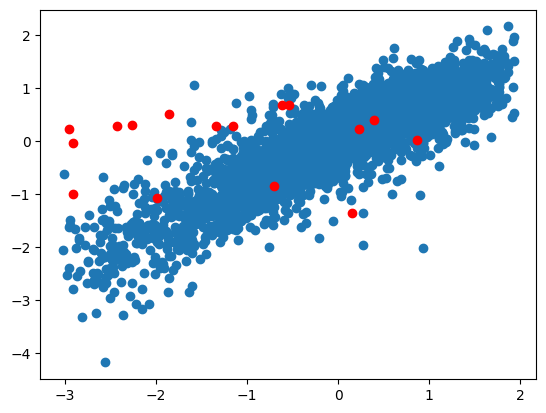

KeyboardInterrupt: 

In [11]:
train, valid, test = molnet_loader("lipo")
train_loader, valid_loader, test_loader = molnet_to_pyg(train, valid, test, label_type=torch.float)

num_node_features = train_loader.dataset[0].num_node_features
num_edge_features = train_loader.dataset[0].num_edge_features
model = GNNSetRepRegressor(num_node_features, 256, 2, num_edge_features, 16, 42)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

explainer = RegressionExplainer(model, train_loader)

trainer = Trainer(
    model,
    optimizer,
    criterion,
    200,
    [R2Score(), RootMeanSquaredError()],
    [R2Score(), RootMeanSquaredError()],
    [R2Score(), RootMeanSquaredError()],
    monitor_metric=1,
    explainer=explainer
)

trainer.train(train_loader, valid_loader)
trainer.test(test_loader)